In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.lstm = nn.LSTM(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        lstm_out, hidden = self.lstm(x, hidden)
        last_output = lstm_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 4000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # LSTM hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 4000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 3341
Total number of data samples in valid_loader: 1113
Total number of data samples in test_loader: 1114


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = LSTM(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [23]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/4000_LSTM') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 5/5 [00:00<00:00, 507.07it/s]


Model saved
TRAIN LOSS = 0.0023495389811473847, TRAIN ACC = 0.7171505537264292, 
VALID LOSS = 0.002411821353360542, VALID ACC = 0.7250673854447439, 
epoch 2


100%|██████████| 5/5 [00:00<00:00, 508.78it/s]


Model saved
TRAIN LOSS = 0.002208142143564644, TRAIN ACC = 0.7485782699790482, 
VALID LOSS = 0.0022606600916075044, VALID ACC = 0.7511230907457322, 
epoch 3


100%|██████████| 5/5 [00:00<00:00, 82.00it/s]


Model saved
TRAIN LOSS = 0.0020639676599579636, TRAIN ACC = 0.7662376533971865, 
VALID LOSS = 0.0021741504831991, VALID ACC = 0.7681940700808625, 
epoch 4


100%|██████████| 5/5 [00:00<00:00, 500.44it/s]


TRAIN LOSS = 0.0019371834157363129, TRAIN ACC = 0.7803052978150254, 
VALID LOSS = 0.0021725768509579476, VALID ACC = 0.7672955974842768, 
epoch 5


100%|██████████| 5/5 [00:00<00:00, 470.51it/s]


TRAIN LOSS = 0.001980879222229904, TRAIN ACC = 0.764741095480395, 
VALID LOSS = 0.0021405774574502568, VALID ACC = 0.7574123989218329, 
epoch 6


100%|██████████| 5/5 [00:00<00:00, 500.84it/s]


Model saved
TRAIN LOSS = 0.001891141940790249, TRAIN ACC = 0.7800059862316672, 
VALID LOSS = 0.00201115413817434, VALID ACC = 0.7726864330637916, 
epoch 7


100%|██████████| 5/5 [00:00<00:00, 486.12it/s]


Model saved
TRAIN LOSS = 0.001755420170976387, TRAIN ACC = 0.7764142472313679, 
VALID LOSS = 0.0019208989160508587, VALID ACC = 0.7780772686433064, 
epoch 8


100%|██████████| 5/5 [00:00<00:00, 467.36it/s]


TRAIN LOSS = 0.0018562117724745476, TRAIN ACC = 0.7785094283148758, 
VALID LOSS = 0.00200591581101259, VALID ACC = 0.7780772686433064, 
epoch 9


100%|██████████| 5/5 [00:00<00:00, 507.04it/s]


TRAIN LOSS = 0.0018262598140622926, TRAIN ACC = 0.7844956599820413, 
VALID LOSS = 0.0019432952408306467, VALID ACC = 0.7690925426774483, 
epoch 10


100%|██████████| 5/5 [00:00<00:00, 504.50it/s]


TRAIN LOSS = 0.0017587536378950103, TRAIN ACC = 0.7985633043998803, 
VALID LOSS = 0.0019361047410579382, VALID ACC = 0.7762803234501348, 
epoch 11


100%|██████████| 5/5 [00:00<00:00, 507.22it/s]


TRAIN LOSS = 0.0016458898791650283, TRAIN ACC = 0.7910805148159233, 
VALID LOSS = 0.0017879445437151145, VALID ACC = 0.7672955974842768, 
epoch 12


100%|██████████| 5/5 [00:00<00:00, 508.12it/s]


TRAIN LOSS = 0.0015922204993578247, TRAIN ACC = 0.7946722538162226, 
VALID LOSS = 0.002053310232770839, VALID ACC = 0.7654986522911051, 
epoch 13


100%|██████████| 5/5 [00:00<00:00, 498.11it/s]


TRAIN LOSS = 0.0016014127852994502, TRAIN ACC = 0.7812032325651003, 
VALID LOSS = 0.0018741616984261978, VALID ACC = 0.7699910152740341, 
epoch 14


100%|██████████| 5/5 [00:00<00:00, 496.38it/s]


TRAIN LOSS = 0.0020147569876736203, TRAIN ACC = 0.7922777611493564, 
VALID LOSS = 0.0023386946478515516, VALID ACC = 0.7744833782569631, 
epoch 15


100%|██████████| 5/5 [00:00<00:00, 504.98it/s]


Model saved
TRAIN LOSS = 0.0017026049385738744, TRAIN ACC = 0.8096378329841365, 
VALID LOSS = 0.001994889942462232, VALID ACC = 0.7852650494159928, 
epoch 16


100%|██████████| 5/5 [00:00<00:00, 500.22it/s]


Model saved
TRAIN LOSS = 0.0016534812469676525, TRAIN ACC = 0.8063454055671955, 
VALID LOSS = 0.0017702803350416049, VALID ACC = 0.7951482479784366, 
epoch 17


100%|██████████| 5/5 [00:00<00:00, 426.35it/s]


Model saved
TRAIN LOSS = 0.0014442088842320606, TRAIN ACC = 0.8078419634839868, 
VALID LOSS = 0.001702625609044009, VALID ACC = 0.8032345013477089, 
epoch 18


100%|██████████| 5/5 [00:00<00:00, 499.85it/s]


TRAIN LOSS = 0.0014289574364779488, TRAIN ACC = 0.80903920981742, 
VALID LOSS = 0.0018770550674719524, VALID ACC = 0.7924528301886793, 
epoch 19


100%|██████████| 5/5 [00:00<00:00, 501.42it/s]


Model saved
TRAIN LOSS = 0.0014455734488137, TRAIN ACC = 0.8081412750673451, 
VALID LOSS = 0.0016191703504200787, VALID ACC = 0.8122192273135669, 
epoch 20


100%|██████████| 5/5 [00:00<00:00, 493.85it/s]


Model saved
TRAIN LOSS = 0.001361141569490955, TRAIN ACC = 0.8284944627357079, 
VALID LOSS = 0.0015986857120774398, VALID ACC = 0.8149146451033243, 
epoch 21


100%|██████████| 5/5 [00:00<00:00, 506.09it/s]


TRAIN LOSS = 0.0013902192654919388, TRAIN ACC = 0.8135288835677941, 
VALID LOSS = 0.0016518244846169196, VALID ACC = 0.7861635220125787, 
epoch 22


100%|██████████| 5/5 [00:00<00:00, 490.81it/s]


TRAIN LOSS = 0.0013102625960256125, TRAIN ACC = 0.8246034121520502, 
VALID LOSS = 0.001632707780904847, VALID ACC = 0.8041329739442947, 
epoch 23


100%|██████████| 5/5 [00:00<00:00, 501.47it/s]


TRAIN LOSS = 0.0013534147576706311, TRAIN ACC = 0.8299910206524993, 
VALID LOSS = 0.0016220319356772671, VALID ACC = 0.8023360287511231, 
epoch 24


100%|██████████| 5/5 [00:00<00:00, 504.15it/s]


Model saved
TRAIN LOSS = 0.0012404422084216905, TRAIN ACC = 0.8428614187369051, 
VALID LOSS = 0.0014949321264847912, VALID ACC = 0.8292902066486972, 
epoch 25


100%|██████████| 5/5 [00:00<00:00, 503.28it/s]


TRAIN LOSS = 0.0012039564677035512, TRAIN ACC = 0.8473510924872792, 
VALID LOSS = 0.0015415329710385442, VALID ACC = 0.8247978436657682, 
epoch 26


100%|██████████| 5/5 [00:00<00:00, 505.63it/s]


Model saved
TRAIN LOSS = 0.0011547424280511445, TRAIN ACC = 0.8602214905716852, 
VALID LOSS = 0.00137154060446884, VALID ACC = 0.862533692722372, 
epoch 27


100%|██████████| 5/5 [00:00<00:00, 503.65it/s]


Model saved
TRAIN LOSS = 0.0010577509527040863, TRAIN ACC = 0.8868602214905716, 
VALID LOSS = 0.0014311606725485391, VALID ACC = 0.8643306379155435, 
epoch 28


100%|██████████| 5/5 [00:00<00:00, 505.14it/s]


TRAIN LOSS = 0.0011493991062477727, TRAIN ACC = 0.8760850044896737, 
VALID LOSS = 0.0014248291383642177, VALID ACC = 0.8571428571428571, 
epoch 29


100%|██████████| 5/5 [00:00<00:00, 499.43it/s]


TRAIN LOSS = 0.001473029357913867, TRAIN ACC = 0.8374738102364562, 
VALID LOSS = 0.0019317314845425314, VALID ACC = 0.7690925426774483, 
epoch 30


100%|██████████| 5/5 [00:00<00:00, 494.56it/s]


TRAIN LOSS = 0.0015775441400878482, TRAIN ACC = 0.7967674348997306, 
VALID LOSS = 0.001734485844717514, VALID ACC = 0.8104222821203954, 
epoch 31


100%|██████████| 5/5 [00:00<00:00, 505.59it/s]


TRAIN LOSS = 0.0013095911874345804, TRAIN ACC = 0.8452559114037713, 
VALID LOSS = 0.0014403551575951179, VALID ACC = 0.8517520215633423, 
epoch 32


100%|██████████| 5/5 [00:00<00:00, 497.88it/s]


TRAIN LOSS = 0.0012309342328391008, TRAIN ACC = 0.8617180484884766, 
VALID LOSS = 0.001561637087545198, VALID ACC = 0.834681042228212, 
epoch 33


100%|██████████| 5/5 [00:00<00:00, 133.11it/s]


TRAIN LOSS = 0.0011030194405059334, TRAIN ACC = 0.86979946123915, 
VALID LOSS = 0.0014205706462277448, VALID ACC = 0.8598382749326146, 
epoch 34


100%|██████████| 5/5 [00:00<00:00, 498.10it/s]


TRAIN LOSS = 0.001063972818605274, TRAIN ACC = 0.8790781203232565, 
VALID LOSS = 0.0015676509445032769, VALID ACC = 0.8454627133872417, 
epoch 35


100%|██████████| 5/5 [00:00<00:00, 456.27it/s]


TRAIN LOSS = 0.0012895765418030124, TRAIN ACC = 0.8608201137384017, 
VALID LOSS = 0.0016584744189948727, VALID ACC = 0.834681042228212, 
epoch 36


100%|██████████| 5/5 [00:00<00:00, 492.44it/s]


Model saved
TRAIN LOSS = 0.0011277001789321945, TRAIN ACC = 0.8721939539060162, 
VALID LOSS = 0.0013076745489108488, VALID ACC = 0.8697214734950584, 
epoch 37


100%|██████████| 5/5 [00:00<00:00, 493.48it/s]


TRAIN LOSS = 0.0010285650370756832, TRAIN ACC = 0.89583956899132, 
VALID LOSS = 0.0013667380793717994, VALID ACC = 0.8616352201257862, 
epoch 38


100%|██████████| 5/5 [00:00<00:00, 482.70it/s]


TRAIN LOSS = 0.001067382695788361, TRAIN ACC = 0.8826698593235558, 
VALID LOSS = 0.0013649781759215815, VALID ACC = 0.8553459119496856, 
epoch 39


100%|██████████| 5/5 [00:00<00:00, 505.35it/s]


Model saved
TRAIN LOSS = 0.0009168232363235875, TRAIN ACC = 0.9042202933253517, 
VALID LOSS = 0.0011534540774258855, VALID ACC = 0.8823000898472596, 
epoch 40


100%|██████████| 5/5 [00:00<00:00, 488.80it/s]


TRAIN LOSS = 0.00084371012918466, TRAIN ACC = 0.9084106554923675, 
VALID LOSS = 0.001264901562306866, VALID ACC = 0.8751123090745733, 
epoch 41


100%|██████████| 5/5 [00:00<00:00, 492.09it/s]


TRAIN LOSS = 0.0008949105458072615, TRAIN ACC = 0.9087099670757258, 
VALID LOSS = 0.0012258040214163273, VALID ACC = 0.8796046720575023, 
epoch 42


100%|██████████| 5/5 [00:00<00:00, 497.26it/s]


TRAIN LOSS = 0.0009585879531244931, TRAIN ACC = 0.9060161628255013, 
VALID LOSS = 0.0012455933124014417, VALID ACC = 0.8742138364779874, 
epoch 43


100%|██████████| 5/5 [00:00<00:00, 495.42it/s]


TRAIN LOSS = 0.0009179692297272966, TRAIN ACC = 0.9099072134091589, 
VALID LOSS = 0.0012412393751812753, VALID ACC = 0.8769092542677448, 
epoch 44


100%|██████████| 5/5 [00:00<00:00, 497.73it/s]


TRAIN LOSS = 0.0009573523966504656, TRAIN ACC = 0.9066147859922179, 
VALID LOSS = 0.0013273967779764482, VALID ACC = 0.867026055705301, 
epoch 45


100%|██████████| 5/5 [00:00<00:00, 507.69it/s]


TRAIN LOSS = 0.0010565997409949007, TRAIN ACC = 0.8892547141574378, 
VALID LOSS = 0.0013896125935265746, VALID ACC = 0.8652291105121294, 
epoch 46


100%|██████████| 5/5 [00:00<00:00, 506.33it/s]


Model saved
TRAIN LOSS = 0.0008984099414597654, TRAIN ACC = 0.9066147859922179, 
VALID LOSS = 0.0012580416728437001, VALID ACC = 0.8840970350404312, 
epoch 47


100%|██████████| 5/5 [00:00<00:00, 505.73it/s]


TRAIN LOSS = 0.0007634229268973475, TRAIN ACC = 0.923974857826998, 
VALID LOSS = 0.0013622188236085766, VALID ACC = 0.8697214734950584, 
epoch 48


100%|██████████| 5/5 [00:00<00:00, 505.03it/s]


TRAIN LOSS = 0.0008315393593596042, TRAIN ACC = 0.9137982639928165, 
VALID LOSS = 0.0015841020138972746, VALID ACC = 0.8535489667565139, 
epoch 49


100%|██████████| 5/5 [00:00<00:00, 507.36it/s]


TRAIN LOSS = 0.0009198057655087847, TRAIN ACC = 0.9033223585752769, 
VALID LOSS = 0.0015531556357806155, VALID ACC = 0.8778077268643306, 
epoch 50


100%|██████████| 5/5 [00:00<00:00, 501.94it/s]


TRAIN LOSS = 0.0009531029476373005, TRAIN ACC = 0.9081113439090093, 
VALID LOSS = 0.001403222106537729, VALID ACC = 0.8598382749326146, 
epoch 51


100%|██████████| 5/5 [00:00<00:00, 506.02it/s]


TRAIN LOSS = 0.0008561772586199668, TRAIN ACC = 0.9191858724932654, 
VALID LOSS = 0.0013117153475333846, VALID ACC = 0.8706199460916442, 
epoch 52


100%|██████████| 5/5 [00:00<00:00, 499.64it/s]


Model saved
TRAIN LOSS = 0.0006509010474576953, TRAIN ACC = 0.933852140077821, 
VALID LOSS = 0.0012018786206078338, VALID ACC = 0.8921832884097035, 
epoch 53


100%|██████████| 5/5 [00:00<00:00, 502.32it/s]


TRAIN LOSS = 0.0006653741938701756, TRAIN ACC = 0.9398383717449865, 
VALID LOSS = 0.0012065569961381623, VALID ACC = 0.8876909254267745, 
epoch 54


100%|██████████| 5/5 [00:00<00:00, 429.05it/s]


Model saved
TRAIN LOSS = 0.0006603472664020119, TRAIN ACC = 0.9314576474109548, 
VALID LOSS = 0.001276222709482678, VALID ACC = 0.894878706199461, 
epoch 55


100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Model saved
TRAIN LOSS = 0.0005588435133892916, TRAIN ACC = 0.9485184076623765, 
VALID LOSS = 0.0011841483407478983, VALID ACC = 0.89937106918239, 
epoch 56


100%|██████████| 5/5 [00:00<00:00, 507.98it/s]


TRAIN LOSS = 0.0007149046100174299, TRAIN ACC = 0.9320562705776714, 
VALID LOSS = 0.0012149050336428195, VALID ACC = 0.8885893980233602, 
epoch 57


100%|██████████| 5/5 [00:00<00:00, 503.24it/s]


TRAIN LOSS = 0.000682566826731029, TRAIN ACC = 0.9329542053277462, 
VALID LOSS = 0.0012276587674774143, VALID ACC = 0.8787061994609164, 
epoch 58


100%|██████████| 5/5 [00:00<00:00, 499.67it/s]


TRAIN LOSS = 0.0006788785462606384, TRAIN ACC = 0.9269679736605807, 
VALID LOSS = 0.0013999914330399368, VALID ACC = 0.8903863432165319, 
epoch 59


100%|██████████| 5/5 [00:00<00:00, 486.16it/s]


TRAIN LOSS = 0.0006889644313343839, TRAIN ACC = 0.927267285243939, 
VALID LOSS = 0.0012121827267143818, VALID ACC = 0.8823000898472596, 
epoch 60


100%|██████████| 5/5 [00:00<00:00, 503.61it/s]


TRAIN LOSS = 0.000571931110495973, TRAIN ACC = 0.9410356180784196, 
VALID LOSS = 0.0012024428029373114, VALID ACC = 0.8912848158131177, 
epoch 61


100%|██████████| 5/5 [00:00<00:00, 496.74it/s]


TRAIN LOSS = 0.0004860641302658533, TRAIN ACC = 0.9503142771625261, 
VALID LOSS = 0.0012651903476140999, VALID ACC = 0.89937106918239, 
epoch 62


100%|██████████| 5/5 [00:00<00:00, 502.83it/s]


Model saved
TRAIN LOSS = 0.0004776682558619166, TRAIN ACC = 0.9515115234959592, 
VALID LOSS = 0.0011810712978203664, VALID ACC = 0.9056603773584906, 
epoch 63


100%|██████████| 5/5 [00:00<00:00, 503.64it/s]


TRAIN LOSS = 0.0003879991463427057, TRAIN ACC = 0.9604908709967076, 
VALID LOSS = 0.0012966504610023943, VALID ACC = 0.9029649595687331, 
epoch 64


100%|██████████| 5/5 [00:00<00:00, 502.22it/s]


Model saved
TRAIN LOSS = 0.0004940657996018109, TRAIN ACC = 0.9521101466626758, 
VALID LOSS = 0.0013622298555554084, VALID ACC = 0.9065588499550764, 
epoch 65


100%|██████████| 5/5 [00:00<00:00, 493.24it/s]


TRAIN LOSS = 0.0006696590448489127, TRAIN ACC = 0.9449266686620772, 
VALID LOSS = 0.0014206315897010192, VALID ACC = 0.8912848158131177, 
epoch 66


100%|██████████| 5/5 [00:00<00:00, 498.87it/s]


TRAIN LOSS = 0.0006948664106497755, TRAIN ACC = 0.9380425022448369, 
VALID LOSS = 0.0013201183707244955, VALID ACC = 0.8939802336028752, 
epoch 67


100%|██████████| 5/5 [00:00<00:00, 489.35it/s]


TRAIN LOSS = 0.000642363879627826, TRAIN ACC = 0.9395390601616282, 
VALID LOSS = 0.0013965075870729841, VALID ACC = 0.8876909254267745, 
epoch 68


100%|██████████| 5/5 [00:00<00:00, 499.16it/s]


TRAIN LOSS = 0.0007181327965080435, TRAIN ACC = 0.9281652199940138, 
VALID LOSS = 0.0011483490306412113, VALID ACC = 0.8912848158131177, 
epoch 69


100%|██████████| 5/5 [00:00<00:00, 507.05it/s]


Model saved
TRAIN LOSS = 0.0005647794640963393, TRAIN ACC = 0.9464232265788686, 
VALID LOSS = 0.0012525444296385294, VALID ACC = 0.9110512129380054, 
epoch 70


100%|██████████| 5/5 [00:00<00:00, 497.53it/s]


TRAIN LOSS = 0.0005114376500351491, TRAIN ACC = 0.9592936246632745, 
VALID LOSS = 0.0016484635163296051, VALID ACC = 0.8975741239892183, 
epoch 71


100%|██████████| 5/5 [00:00<00:00, 456.82it/s]


TRAIN LOSS = 0.0009714384496087123, TRAIN ACC = 0.9194851840766237, 
VALID LOSS = 0.001602044484686016, VALID ACC = 0.8706199460916442, 
epoch 72


100%|██████████| 5/5 [00:00<00:00, 504.14it/s]


TRAIN LOSS = 0.0007292252458772485, TRAIN ACC = 0.9329542053277462, 
VALID LOSS = 0.0012432482605674517, VALID ACC = 0.889487870619946, 
epoch 73


100%|██████████| 5/5 [00:00<00:00, 505.00it/s]


TRAIN LOSS = 0.0008348491052887605, TRAIN ACC = 0.9281652199940138, 
VALID LOSS = 0.0013420514206787754, VALID ACC = 0.8885893980233602, 
epoch 74


100%|██████████| 5/5 [00:00<00:00, 505.36it/s]


TRAIN LOSS = 0.0006727243845279401, TRAIN ACC = 0.9374438790781203, 
VALID LOSS = 0.0014197042099763333, VALID ACC = 0.8706199460916442, 
epoch 75


100%|██████████| 5/5 [00:00<00:00, 405.00it/s]


TRAIN LOSS = 0.000590898870387073, TRAIN ACC = 0.9482190960790182, 
VALID LOSS = 0.001192316533420285, VALID ACC = 0.9002695417789758, 
epoch 76


100%|██████████| 5/5 [00:00<00:00, 507.49it/s]


TRAIN LOSS = 0.0004369960091528654, TRAIN ACC = 0.9601915594133493, 
VALID LOSS = 0.001411776149583527, VALID ACC = 0.8885893980233602, 
epoch 77


100%|██████████| 5/5 [00:00<00:00, 386.59it/s]


TRAIN LOSS = 0.00045035207804110694, TRAIN ACC = 0.959892247829991, 
VALID LOSS = 0.0013507429346348505, VALID ACC = 0.9056603773584906, 
epoch 78


100%|██████████| 5/5 [00:00<00:00, 510.26it/s]


TRAIN LOSS = 0.0007838576818004906, TRAIN ACC = 0.9341514516611793, 
VALID LOSS = 0.0012904853967536385, VALID ACC = 0.8876909254267745, 
epoch 79


100%|██████████| 5/5 [00:00<00:00, 502.54it/s]


TRAIN LOSS = 0.0009389084074462255, TRAIN ACC = 0.9051182280754265, 
VALID LOSS = 0.0014296676110064565, VALID ACC = 0.8787061994609164, 
epoch 80


100%|██████████| 5/5 [00:00<00:00, 499.87it/s]


TRAIN LOSS = 0.0006905930800838978, TRAIN ACC = 0.9332535169111045, 
VALID LOSS = 0.0013731298876151455, VALID ACC = 0.8876909254267745, 
epoch 81


100%|██████████| 5/5 [00:00<00:00, 499.10it/s]


TRAIN LOSS = 0.000516631650250317, TRAIN ACC = 0.949117030829093, 
VALID LOSS = 0.0012007125009852065, VALID ACC = 0.903863432165319, 
epoch 82


100%|██████████| 5/5 [00:00<00:00, 406.54it/s]


TRAIN LOSS = 0.0005014146264476338, TRAIN ACC = 0.9503142771625261, 
VALID LOSS = 0.0011615564532892616, VALID ACC = 0.89937106918239, 
epoch 83


100%|██████████| 5/5 [00:00<00:00, 505.54it/s]


Model saved
TRAIN LOSS = 0.0005790835407564506, TRAIN ACC = 0.953307392996109, 
VALID LOSS = 0.0013144001003224251, VALID ACC = 0.9119496855345912, 
epoch 84


100%|██████████| 5/5 [00:00<00:00, 498.55it/s]


TRAIN LOSS = 0.0005065498751496455, TRAIN ACC = 0.9595929362466328, 
VALID LOSS = 0.0011248914700634075, VALID ACC = 0.9119496855345912, 
epoch 85


100%|██████████| 5/5 [00:00<00:00, 499.48it/s]


TRAIN LOSS = 0.0003967588638902977, TRAIN ACC = 0.9583956899131997, 
VALID LOSS = 0.0011158728936933122, VALID ACC = 0.9083557951482479, 
epoch 86


100%|██████████| 5/5 [00:00<00:00, 471.40it/s]


Model saved
TRAIN LOSS = 0.0003248956327629603, TRAIN ACC = 0.9715653995809638, 
VALID LOSS = 0.001217497688419414, VALID ACC = 0.9200359389038635, 
epoch 87


100%|██████████| 5/5 [00:00<00:00, 497.46it/s]


TRAIN LOSS = 0.0003068088064629744, TRAIN ACC = 0.97395989224783, 
VALID LOSS = 0.0013774841863190067, VALID ACC = 0.9137466307277629, 
epoch 88


100%|██████████| 5/5 [00:00<00:00, 500.20it/s]


TRAIN LOSS = 0.0003583611687993761, TRAIN ACC = 0.9745585154145465, 
VALID LOSS = 0.0012318294726292077, VALID ACC = 0.917340521114106, 
epoch 89


100%|██████████| 5/5 [00:00<00:00, 488.56it/s]


TRAIN LOSS = 0.0003581231259828697, TRAIN ACC = 0.9667764142472314, 
VALID LOSS = 0.0012093402599281592, VALID ACC = 0.9119496855345912, 
epoch 90


100%|██████████| 5/5 [00:00<00:00, 504.96it/s]


TRAIN LOSS = 0.0003010383765309362, TRAIN ACC = 0.97395989224783, 
VALID LOSS = 0.0016330949701067572, VALID ACC = 0.9002695417789758, 
epoch 91


100%|██████████| 5/5 [00:00<00:00, 444.41it/s]


TRAIN LOSS = 0.0002949077405193829, TRAIN ACC = 0.97395989224783, 
VALID LOSS = 0.0011026041192292954, VALID ACC = 0.9191374663072777, 
epoch 92


100%|██████████| 5/5 [00:00<00:00, 507.47it/s]


TRAIN LOSS = 0.00022236357321218437, TRAIN ACC = 0.9820413049985034, 
VALID LOSS = 0.0014203720444082035, VALID ACC = 0.9182389937106918, 
epoch 93


100%|██████████| 5/5 [00:00<00:00, 501.10it/s]


TRAIN LOSS = 0.00027999773796338927, TRAIN ACC = 0.9742592038311882, 
VALID LOSS = 0.0012888930476900701, VALID ACC = 0.9137466307277629, 
epoch 94


100%|██████████| 5/5 [00:00<00:00, 508.06it/s]


TRAIN LOSS = 0.00023191006097633728, TRAIN ACC = 0.9796468123316372, 
VALID LOSS = 0.0014360104449033094, VALID ACC = 0.9110512129380054, 
epoch 95


100%|██████████| 5/5 [00:00<00:00, 501.23it/s]


TRAIN LOSS = 0.00027599188771496914, TRAIN ACC = 0.9787488775815624, 
VALID LOSS = 0.001415077566779206, VALID ACC = 0.9020664869721473, 
epoch 96


100%|██████████| 5/5 [00:00<00:00, 516.78it/s]


TRAIN LOSS = 0.00021976885290755658, TRAIN ACC = 0.9799461239149955, 
VALID LOSS = 0.0017597642120539554, VALID ACC = 0.89937106918239, 
epoch 97


100%|██████████| 5/5 [00:00<00:00, 499.29it/s]


TRAIN LOSS = 0.00033043698786538507, TRAIN ACC = 0.9733612690811134, 
VALID LOSS = 0.0013255404253211625, VALID ACC = 0.9119496855345912, 
epoch 98


100%|██████████| 5/5 [00:00<00:00, 502.35it/s]


TRAIN LOSS = 0.0003000170993737138, TRAIN ACC = 0.9817419934151451, 
VALID LOSS = 0.0014598321802211257, VALID ACC = 0.9164420485175202, 
epoch 99


100%|██████████| 5/5 [00:00<00:00, 509.69it/s]


Model saved
TRAIN LOSS = 0.00022544220674741735, TRAIN ACC = 0.980544747081712, 
VALID LOSS = 0.001217566972794237, VALID ACC = 0.9245283018867925, 
epoch 100


100%|██████████| 5/5 [00:00<00:00, 503.41it/s]


TRAIN LOSS = 0.00022281415779193747, TRAIN ACC = 0.9799461239149955, 
VALID LOSS = 0.0011676755890263593, VALID ACC = 0.9209344115004492, 
epoch 101


100%|██████████| 5/5 [00:00<00:00, 512.41it/s]


TRAIN LOSS = 0.0002065274548883818, TRAIN ACC = 0.9871296019155942, 
VALID LOSS = 0.0015438964853175352, VALID ACC = 0.9191374663072777, 
epoch 102


100%|██████████| 5/5 [00:00<00:00, 503.06it/s]


TRAIN LOSS = 0.00016898614574927337, TRAIN ACC = 0.9865309787488776, 
VALID LOSS = 0.001316288625026542, VALID ACC = 0.9245283018867925, 
epoch 103


100%|██████████| 5/5 [00:00<00:00, 225.98it/s]


Model saved
TRAIN LOSS = 0.00011540997966586544, TRAIN ACC = 0.9901227177491769, 
VALID LOSS = 0.001298171544224961, VALID ACC = 0.9326145552560647, 
epoch 104


100%|██████████| 5/5 [00:00<00:00, 501.16it/s]


TRAIN LOSS = 0.00017517004346051854, TRAIN ACC = 0.9886261598323856, 
VALID LOSS = 0.0013904920030261415, VALID ACC = 0.9308176100628931, 
epoch 105


100%|██████████| 5/5 [00:00<00:00, 505.69it/s]


TRAIN LOSS = 0.00039972172561108583, TRAIN ACC = 0.9712660879976055, 
VALID LOSS = 0.001446200295385753, VALID ACC = 0.9182389937106918, 
epoch 106


100%|██████████| 5/5 [00:00<00:00, 501.17it/s]


TRAIN LOSS = 0.00036283671483508984, TRAIN ACC = 0.9694702184974558, 
VALID LOSS = 0.0012815728422123788, VALID ACC = 0.9245283018867925, 
epoch 107


100%|██████████| 5/5 [00:00<00:00, 502.66it/s]


TRAIN LOSS = 0.00029714966392988077, TRAIN ACC = 0.9778509428314875, 
VALID LOSS = 0.0011608669967771326, VALID ACC = 0.9200359389038635, 
epoch 108


100%|██████████| 5/5 [00:00<00:00, 431.83it/s]


TRAIN LOSS = 0.00020996524080683178, TRAIN ACC = 0.9841364860820113, 
VALID LOSS = 0.0012191234680306022, VALID ACC = 0.9200359389038635, 
epoch 109


100%|██████████| 5/5 [00:00<00:00, 499.25it/s]


TRAIN LOSS = 0.00013445895954083446, TRAIN ACC = 0.9889254714157438, 
VALID LOSS = 0.001143957606223073, VALID ACC = 0.9317160826594789, 
epoch 110


100%|██████████| 5/5 [00:00<00:00, 499.11it/s]


TRAIN LOSS = 0.00010681960344831945, TRAIN ACC = 0.9922178988326849, 
VALID LOSS = 0.0012874244063798095, VALID ACC = 0.9272237196765498, 
epoch 111


100%|██████████| 5/5 [00:00<00:00, 471.30it/s]


TRAIN LOSS = 0.00016840357100381996, TRAIN ACC = 0.9886261598323856, 
VALID LOSS = 0.0013496337553882856, VALID ACC = 0.9245283018867925, 
epoch 112


100%|██████████| 5/5 [00:00<00:00, 508.26it/s]


TRAIN LOSS = 0.0001784934843752385, TRAIN ACC = 0.9853337324154445, 
VALID LOSS = 0.0014636169546697981, VALID ACC = 0.9074573225516622, 
epoch 113


100%|██████████| 5/5 [00:00<00:00, 491.00it/s]


TRAIN LOSS = 0.000146598141753042, TRAIN ACC = 0.9910206524992518, 
VALID LOSS = 0.0012899601609451966, VALID ACC = 0.9299191374663073, 
epoch 114


100%|██████████| 5/5 [00:00<00:00, 504.89it/s]


TRAIN LOSS = 9.983561378874418e-05, TRAIN ACC = 0.993415145166118, 
VALID LOSS = 0.0012915845080098908, VALID ACC = 0.9299191374663073, 
epoch 115


100%|██████████| 5/5 [00:00<00:00, 498.62it/s]


TRAIN LOSS = 6.591260762964937e-05, TRAIN ACC = 0.9955103262496259, 
VALID LOSS = 0.0014519964186650402, VALID ACC = 0.9308176100628931, 
epoch 116


100%|██████████| 5/5 [00:00<00:00, 406.57it/s]


TRAIN LOSS = 7.380421859633419e-05, TRAIN ACC = 0.994612391499551, 
VALID LOSS = 0.0014412353770859264, VALID ACC = 0.9299191374663073, 
epoch 117


100%|██████████| 5/5 [00:00<00:00, 508.01it/s]


TRAIN LOSS = 7.615773738240637e-05, TRAIN ACC = 0.9937144567494762, 
VALID LOSS = 0.002119298920584282, VALID ACC = 0.9092542677448338, 
epoch 118


100%|██████████| 5/5 [00:00<00:00, 508.25it/s]


TRAIN LOSS = 0.0002330343539856399, TRAIN ACC = 0.9856330439988028, 
VALID LOSS = 0.001726255530402774, VALID ACC = 0.912848158131177, 
epoch 119


100%|██████████| 5/5 [00:00<00:00, 503.64it/s]


TRAIN LOSS = 0.00017595227985606334, TRAIN ACC = 0.983837174498653, 
VALID LOSS = 0.0014962254749796783, VALID ACC = 0.9236298292902066, 
epoch 120


100%|██████████| 5/5 [00:00<00:00, 441.32it/s]


TRAIN LOSS = 0.00016468359518152838, TRAIN ACC = 0.9868302903322359, 
VALID LOSS = 0.0016405088801910936, VALID ACC = 0.9227313566936208, 
epoch 121


100%|██████████| 5/5 [00:00<00:00, 505.12it/s]


TRAIN LOSS = 0.00015909250561383197, TRAIN ACC = 0.988027536665669, 
VALID LOSS = 0.0013935982993563765, VALID ACC = 0.9245283018867925, 
epoch 122


100%|██████████| 5/5 [00:00<00:00, 499.31it/s]


TRAIN LOSS = 0.00012514271208360252, TRAIN ACC = 0.9898234061658187, 
VALID LOSS = 0.0016378540502190054, VALID ACC = 0.9236298292902066, 
epoch 123


100%|██████████| 5/5 [00:00<00:00, 510.02it/s]


Model saved
TRAIN LOSS = 6.766394666454342e-05, TRAIN ACC = 0.9961089494163424, 
VALID LOSS = 0.001487030280353995, VALID ACC = 0.9335130278526504, 
epoch 124


100%|██████████| 5/5 [00:00<00:00, 501.21it/s]


TRAIN LOSS = 5.038651203640771e-05, TRAIN ACC = 0.9970068841664173, 
VALID LOSS = 0.0018925057909880687, VALID ACC = 0.9254267744833783, 
epoch 125


100%|██████████| 5/5 [00:00<00:00, 504.85it/s]


TRAIN LOSS = 0.00021796579247207316, TRAIN ACC = 0.9958096378329842, 
VALID LOSS = 0.0017795337017655693, VALID ACC = 0.9227313566936208, 
epoch 126


100%|██████████| 5/5 [00:00<00:00, 509.22it/s]


TRAIN LOSS = 7.283165691316181e-05, TRAIN ACC = 0.9958096378329842, 
VALID LOSS = 0.0017923389001676658, VALID ACC = 0.917340521114106, 
epoch 127


100%|██████████| 5/5 [00:00<00:00, 502.88it/s]


TRAIN LOSS = 0.00011761480829751231, TRAIN ACC = 0.9907213409158935, 
VALID LOSS = 0.002013434886075523, VALID ACC = 0.921832884097035, 
epoch 128


100%|██████████| 5/5 [00:00<00:00, 496.64it/s]


TRAIN LOSS = 0.00011018633330115406, TRAIN ACC = 0.9919185872493266, 
VALID LOSS = 0.0018308334327022556, VALID ACC = 0.9101527403414196, 
epoch 129


100%|██████████| 5/5 [00:00<00:00, 509.54it/s]


TRAIN LOSS = 0.00011772496339499022, TRAIN ACC = 0.9910206524992518, 
VALID LOSS = 0.0019908147091707022, VALID ACC = 0.9119496855345912, 
epoch 130


100%|██████████| 5/5 [00:00<00:00, 506.64it/s]


TRAIN LOSS = 0.00013485347737263542, TRAIN ACC = 0.9904220293325352, 
VALID LOSS = 0.0015416286571113675, VALID ACC = 0.9137466307277629, 
epoch 131


100%|██████████| 5/5 [00:00<00:00, 476.99it/s]


TRAIN LOSS = 9.09064535137441e-05, TRAIN ACC = 0.9943130799161928, 
VALID LOSS = 0.0015624735474265169, VALID ACC = 0.9245283018867925, 
epoch 132


100%|██████████| 5/5 [00:00<00:00, 514.47it/s]


TRAIN LOSS = 0.0001442592996079224, TRAIN ACC = 0.9895240945824604, 
VALID LOSS = 0.0014550800486287873, VALID ACC = 0.9254267744833783, 
epoch 133


100%|██████████| 5/5 [00:00<00:00, 476.90it/s]


TRAIN LOSS = 0.00012665544545951984, TRAIN ACC = 0.99131996408261, 
VALID LOSS = 0.0016286238452280736, VALID ACC = 0.921832884097035, 
epoch 134


100%|██████████| 5/5 [00:00<00:00, 477.65it/s]


TRAIN LOSS = 0.00013701199162673386, TRAIN ACC = 0.9925172104160431, 
VALID LOSS = 0.0016116191166966002, VALID ACC = 0.9182389937106918, 
epoch 135


100%|██████████| 5/5 [00:00<00:00, 507.33it/s]


TRAIN LOSS = 6.243748074756761e-05, TRAIN ACC = 0.9958096378329842, 
VALID LOSS = 0.0016777631621690667, VALID ACC = 0.9245283018867925, 
epoch 136


100%|██████████| 5/5 [00:00<00:00, 461.16it/s]


TRAIN LOSS = 8.555416895014749e-05, TRAIN ACC = 0.9949117030829093, 
VALID LOSS = 0.001924055579109226, VALID ACC = 0.9119496855345912, 
epoch 137


100%|██████████| 5/5 [00:00<00:00, 507.26it/s]


TRAIN LOSS = 8.056984961172802e-05, TRAIN ACC = 0.9958096378329842, 
VALID LOSS = 0.0019920943346734745, VALID ACC = 0.921832884097035, 
epoch 138


100%|██████████| 5/5 [00:00<00:00, 505.92it/s]


TRAIN LOSS = 7.209126410776718e-05, TRAIN ACC = 0.9970068841664173, 
VALID LOSS = 0.0019045611383244462, VALID ACC = 0.9146451033243486, 
epoch 139


100%|██████████| 5/5 [00:00<00:00, 508.62it/s]


TRAIN LOSS = 0.00037292981755425523, TRAIN ACC = 0.9793475007482789, 
VALID LOSS = 0.002146987982516019, VALID ACC = 0.9083557951482479, 
epoch 140


100%|██████████| 5/5 [00:00<00:00, 501.70it/s]


TRAIN LOSS = 0.00022504489787482672, TRAIN ACC = 0.98263992816522, 
VALID LOSS = 0.0017073259949148612, VALID ACC = 0.917340521114106, 
epoch 141


100%|██████████| 5/5 [00:00<00:00, 495.13it/s]


TRAIN LOSS = 0.0001472121286346719, TRAIN ACC = 0.9931158335827597, 
VALID LOSS = 0.0016247838173272474, VALID ACC = 0.9164420485175202, 
epoch 142


100%|██████████| 5/5 [00:00<00:00, 501.04it/s]


TRAIN LOSS = 0.00020549223507121452, TRAIN ACC = 0.9835378629152948, 
VALID LOSS = 0.0024139051328129525, VALID ACC = 0.8751123090745733, 
epoch 143


100%|██████████| 5/5 [00:00<00:00, 507.01it/s]


TRAIN LOSS = 0.00036049267236423223, TRAIN ACC = 0.9694702184974558, 
VALID LOSS = 0.0017711755293291747, VALID ACC = 0.89937106918239, 
epoch 144


100%|██████████| 5/5 [00:00<00:00, 505.58it/s]


TRAIN LOSS = 0.0003459268622825118, TRAIN ACC = 0.9757557617479796, 
VALID LOSS = 0.00128496511231, VALID ACC = 0.9137466307277629, 
epoch 145


100%|██████████| 5/5 [00:00<00:00, 492.96it/s]


TRAIN LOSS = 0.0002112856891036337, TRAIN ACC = 0.983837174498653, 
VALID LOSS = 0.0015191026400148814, VALID ACC = 0.9137466307277629, 
epoch 146


100%|██████████| 5/5 [00:00<00:00, 504.57it/s]


TRAIN LOSS = 0.0001451380835749617, TRAIN ACC = 0.99131996408261, 
VALID LOSS = 0.0013466581287195525, VALID ACC = 0.9236298292902066, 
epoch 147


100%|██████████| 5/5 [00:00<00:00, 499.12it/s]


TRAIN LOSS = 0.00021284928785643154, TRAIN ACC = 0.984735109248728, 
VALID LOSS = 0.0015508350711198723, VALID ACC = 0.917340521114106, 
epoch 148


100%|██████████| 5/5 [00:00<00:00, 487.19it/s]


TRAIN LOSS = 0.00014586357354662868, TRAIN ACC = 0.9931158335827597, 
VALID LOSS = 0.0015413559511344066, VALID ACC = 0.9092542677448338, 
epoch 149


100%|██████████| 5/5 [00:00<00:00, 501.45it/s]


TRAIN LOSS = 0.0003574532823259693, TRAIN ACC = 0.9751571385812631, 
VALID LOSS = 0.002012433469134842, VALID ACC = 0.8957771787960467, 
epoch 150


100%|██████████| 5/5 [00:00<00:00, 506.23it/s]


TRAIN LOSS = 0.00021063470563482503, TRAIN ACC = 0.98263992816522, 
VALID LOSS = 0.0014423131674983325, VALID ACC = 0.9137466307277629, 
epoch 151


100%|██████████| 5/5 [00:00<00:00, 499.77it/s]


TRAIN LOSS = 0.00011377673556002911, TRAIN ACC = 0.9910206524992518, 
VALID LOSS = 0.001590665941932452, VALID ACC = 0.9200359389038635, 
epoch 152


100%|██████████| 5/5 [00:00<00:00, 505.34it/s]


TRAIN LOSS = 6.110613914226137e-05, TRAIN ACC = 0.9976055073331338, 
VALID LOSS = 0.00168236833055707, VALID ACC = 0.9254267744833783, 
epoch 153


100%|██████████| 5/5 [00:00<00:00, 467.14it/s]


TRAIN LOSS = 4.3681687381329276e-05, TRAIN ACC = 0.9970068841664173, 
VALID LOSS = 0.0018406306315625132, VALID ACC = 0.9227313566936208, 
epoch 154


100%|██████████| 5/5 [00:00<00:00, 492.10it/s]


TRAIN LOSS = 2.172934634996251e-05, TRAIN ACC = 0.9988027536665669, 
VALID LOSS = 0.0018401788438855264, VALID ACC = 0.9263252470799641, 
epoch 155


100%|██████████| 5/5 [00:00<00:00, 506.47it/s]


TRAIN LOSS = 1.711454977511644e-05, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0018141905091843516, VALID ACC = 0.9254267744833783, 
epoch 156


100%|██████████| 5/5 [00:00<00:00, 506.68it/s]


TRAIN LOSS = 8.549352883272358e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020629209595977565, VALID ACC = 0.9254267744833783, 
epoch 157


100%|██████████| 5/5 [00:00<00:00, 501.45it/s]


TRAIN LOSS = 7.057178519394129e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020564365847519895, VALID ACC = 0.9272237196765498, 
epoch 158


100%|██████████| 5/5 [00:00<00:00, 501.34it/s]


TRAIN LOSS = 5.027869505408022e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020308834898075537, VALID ACC = 0.9272237196765498, 
epoch 159


100%|██████████| 5/5 [00:00<00:00, 508.99it/s]


TRAIN LOSS = 4.201318542658391e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022347320175770693, VALID ACC = 0.9263252470799641, 
epoch 160


100%|██████████| 5/5 [00:00<00:00, 498.41it/s]


TRAIN LOSS = 3.7956004314218246e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023790574084502133, VALID ACC = 0.9263252470799641, 
epoch 161


100%|██████████| 5/5 [00:00<00:00, 503.31it/s]


TRAIN LOSS = 3.1486740341832772e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002263779936882149, VALID ACC = 0.9263252470799641, 
epoch 162


100%|██████████| 5/5 [00:00<00:00, 507.06it/s]


TRAIN LOSS = 3.095590057541705e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002257012774680824, VALID ACC = 0.9281221922731356, 
epoch 163


100%|██████████| 5/5 [00:00<00:00, 492.61it/s]


TRAIN LOSS = 2.351327087318726e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024041012398102, VALID ACC = 0.9281221922731356, 
epoch 164


100%|██████████| 5/5 [00:00<00:00, 508.34it/s]


TRAIN LOSS = 2.0228782782999563e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022096363200010314, VALID ACC = 0.9281221922731356, 
epoch 165


100%|██████████| 5/5 [00:00<00:00, 505.59it/s]


TRAIN LOSS = 1.695871787955937e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002332708290430842, VALID ACC = 0.9290206648697215, 
epoch 166


100%|██████████| 5/5 [00:00<00:00, 503.99it/s]


TRAIN LOSS = 1.6003555513309876e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024904512866380938, VALID ACC = 0.9290206648697215, 
epoch 167


100%|██████████| 5/5 [00:00<00:00, 499.30it/s]


TRAIN LOSS = 1.4932168533287405e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002669420498293579, VALID ACC = 0.9290206648697215, 
epoch 168


100%|██████████| 5/5 [00:00<00:00, 508.31it/s]


TRAIN LOSS = 1.6766682186558958e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026238554785729313, VALID ACC = 0.9299191374663073, 
epoch 169


100%|██████████| 5/5 [00:00<00:00, 481.67it/s]


TRAIN LOSS = 1.5139842047156758e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023115919861082333, VALID ACC = 0.9299191374663073, 
epoch 170


100%|██████████| 5/5 [00:00<00:00, 502.34it/s]


TRAIN LOSS = 1.243892343319279e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002600120271741005, VALID ACC = 0.9299191374663073, 
epoch 171


100%|██████████| 5/5 [00:00<00:00, 514.17it/s]


TRAIN LOSS = 1.0432068145270753e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024341124729968786, VALID ACC = 0.9299191374663073, 
epoch 172


100%|██████████| 5/5 [00:00<00:00, 505.92it/s]


TRAIN LOSS = 1.0332456251198108e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028400514325041654, VALID ACC = 0.9290206648697215, 
epoch 173


100%|██████████| 5/5 [00:00<00:00, 509.74it/s]


TRAIN LOSS = 1.0377814834476113e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027236395983254707, VALID ACC = 0.9290206648697215, 
epoch 174


100%|██████████| 5/5 [00:00<00:00, 438.18it/s]


TRAIN LOSS = 9.038314500372591e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026309244662710706, VALID ACC = 0.9281221922731356, 
epoch 175


100%|██████████| 5/5 [00:00<00:00, 508.30it/s]


TRAIN LOSS = 8.268840583105425e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027521740769011847, VALID ACC = 0.9281221922731356, 
epoch 176


100%|██████████| 5/5 [00:00<00:00, 498.73it/s]


TRAIN LOSS = 8.370087727418518e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027603757938391865, VALID ACC = 0.9290206648697215, 
epoch 177


100%|██████████| 5/5 [00:00<00:00, 505.86it/s]


TRAIN LOSS = 8.19017160529161e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027542466905239138, VALID ACC = 0.9290206648697215, 
epoch 178


100%|██████████| 5/5 [00:00<00:00, 500.54it/s]


TRAIN LOSS = 7.598056635538948e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024378565269767543, VALID ACC = 0.9299191374663073, 
epoch 179


100%|██████████| 5/5 [00:00<00:00, 501.75it/s]


TRAIN LOSS = 6.88478154195021e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029861603571505347, VALID ACC = 0.9299191374663073, 
epoch 180


100%|██████████| 5/5 [00:00<00:00, 505.51it/s]


TRAIN LOSS = 6.762780866431869e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028693587096660714, VALID ACC = 0.9299191374663073, 
epoch 181


100%|██████████| 5/5 [00:00<00:00, 501.34it/s]


TRAIN LOSS = 5.817398961477393e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028208299788503315, VALID ACC = 0.9299191374663073, 
epoch 182


100%|██████████| 5/5 [00:00<00:00, 505.70it/s]


TRAIN LOSS = 5.791665440446462e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030396441457942063, VALID ACC = 0.9299191374663073, 
epoch 183


100%|██████████| 5/5 [00:00<00:00, 495.29it/s]


TRAIN LOSS = 5.873637830417152e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028903680616740373, VALID ACC = 0.9299191374663073, 
epoch 184


100%|██████████| 5/5 [00:00<00:00, 483.19it/s]


TRAIN LOSS = 5.207613504641786e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031175564937728647, VALID ACC = 0.9290206648697215, 
epoch 185


100%|██████████| 5/5 [00:00<00:00, 503.84it/s]


TRAIN LOSS = 4.836146426234948e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027341003205898318, VALID ACC = 0.9299191374663073, 
epoch 186


100%|██████████| 5/5 [00:00<00:00, 496.43it/s]


TRAIN LOSS = 4.343532723495854e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031137436173139985, VALID ACC = 0.9290206648697215, 
epoch 187


100%|██████████| 5/5 [00:00<00:00, 86.84it/s]


TRAIN LOSS = 4.6360999731138397e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002950973641411849, VALID ACC = 0.9290206648697215, 
epoch 188


100%|██████████| 5/5 [00:00<00:00, 504.61it/s]


TRAIN LOSS = 4.485243861479877e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002818568269090404, VALID ACC = 0.9299191374663073, 
epoch 189


100%|██████████| 5/5 [00:00<00:00, 505.81it/s]


TRAIN LOSS = 4.366956431512145e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003415236308139825, VALID ACC = 0.9299191374663073, 
epoch 190


100%|██████████| 5/5 [00:00<00:00, 506.52it/s]


TRAIN LOSS = 4.3933302670297993e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002885466637315776, VALID ACC = 0.9299191374663073, 
epoch 191


100%|██████████| 5/5 [00:00<00:00, 507.82it/s]


TRAIN LOSS = 4.522198038602198e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003130929650000806, VALID ACC = 0.9299191374663073, 
epoch 192


100%|██████████| 5/5 [00:00<00:00, 495.65it/s]


TRAIN LOSS = 3.9834021834909706e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003088886525753052, VALID ACC = 0.9299191374663073, 
epoch 193


100%|██████████| 5/5 [00:00<00:00, 506.74it/s]


TRAIN LOSS = 3.7581863570471596e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030138697157223162, VALID ACC = 0.9299191374663073, 
epoch 194


100%|██████████| 5/5 [00:00<00:00, 498.75it/s]


TRAIN LOSS = 3.912319213601286e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003069166278153631, VALID ACC = 0.9299191374663073, 
epoch 195


100%|██████████| 5/5 [00:00<00:00, 498.65it/s]


TRAIN LOSS = 3.918260748393469e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029278574553247196, VALID ACC = 0.9290206648697215, 
epoch 196


100%|██████████| 5/5 [00:00<00:00, 492.30it/s]


TRAIN LOSS = 3.2474871452743634e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031372374065909855, VALID ACC = 0.9290206648697215, 
epoch 197


100%|██████████| 5/5 [00:00<00:00, 494.11it/s]


TRAIN LOSS = 2.9869021696566925e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.003083607203662663, VALID ACC = 0.9290206648697215, 
epoch 198


100%|██████████| 5/5 [00:00<00:00, 503.60it/s]


TRAIN LOSS = 3.528382120305124e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030213166279291527, VALID ACC = 0.9290206648697215, 
epoch 199


100%|██████████| 5/5 [00:00<00:00, 504.49it/s]


TRAIN LOSS = 2.6298239085709636e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0032414263256583683, VALID ACC = 0.9281221922731356, 
epoch 200


100%|██████████| 5/5 [00:00<00:00, 506.58it/s]

TRAIN LOSS = 3.2479259785096364e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0034636105113702107, VALID ACC = 0.9281221922731356, 


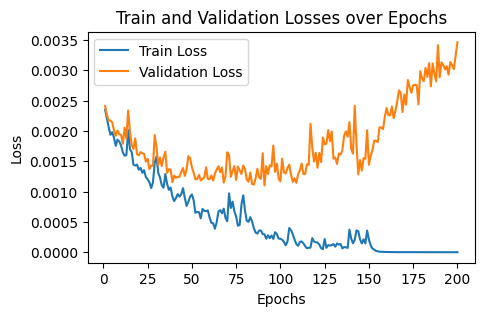

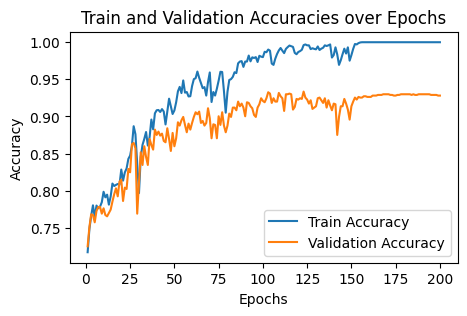

In [24]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [23]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/4000_LSTM_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 354.31it/s]

Best epoch: 123
macro F1 Score: 0.8998727476571851
AUROC: 0.949898491589017
Accuracy: 0.914721723518851


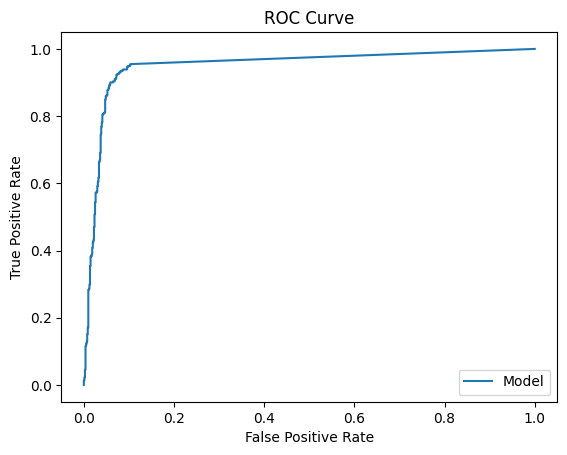

In [28]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)